# Tuberculosis 

## Importing Libraries

In [1]:

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import shutil

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D , Dense
from keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score

import glob
import random
import re

import random
from IPython.display import Image
import matplotlib.cm as cm


%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Download metadata and check the number of images.

In [8]:
DATASET_PATH = r"D:\Nivaran_2.0\Tuberculosis\TB_Chest_Radiography_Database"

df_norm = pd.read_excel(os.path.join(DATASET_PATH, "Normal.metadata.xlsx"))
df_tb = pd.read_excel(os.path.join(DATASET_PATH, "Tuberculosis.metadata.xlsx"))

print("Normal metadata")
print(df_norm.head(2))
print(f"Number of Normal images: {df_norm.shape[0]}")
print("_____________________________")
print("TB metadata")
print(df_tb.head(2))
print(f"Number of Tuberculosis images: {df_tb.shape[0]}")


Normal metadata
  FILE NAME FORMAT     SIZE                                                URL
0  Normal-1    PNG  512*512  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
1  Normal-2    PNG  512*512  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
Number of Normal images: 3500
_____________________________
TB metadata
        FILE NAME FORMAT     SIZE                      URL
0  Tuberculosis-1    PNG  512*512  http://tuberculosis.by/
1  Tuberculosis-2    PNG  512*512  http://tuberculosis.by/
Number of Tuberculosis images: 700


## Merge metadata & Create labels

In [ ]:
df_norm["Tuberculosis"] = 0  # labelling as 0 for binary classification
df_tb["Tuberculosis"] = 1    # labelling as 1 

# Remove unnecessary columns  
df_norm.drop(columns=["FORMAT", "SIZE", "URL"], inplace=True)  
df_tb.drop(columns=["FORMAT", "SIZE", "URL"], inplace=True)  

# Merge both tables into a single dataframe  
df = pd.concat([df_norm, df_tb])  

# Shuffle the data  
df = df.sample(frac=1).reset_index(drop=True)  

# Rename the column "FILE NAME" to "Image"  
df.rename(columns={"FILE NAME": "Image"}, inplace=True)  

# Check the data  
df.head()  


,Image,Tuberculosis
0,Tuberculosis-206,1
1,Normal-1277,0
2,Normal-313,0
3,Normal-2233,0
4,Normal-872,0


## Check the number of images in each class

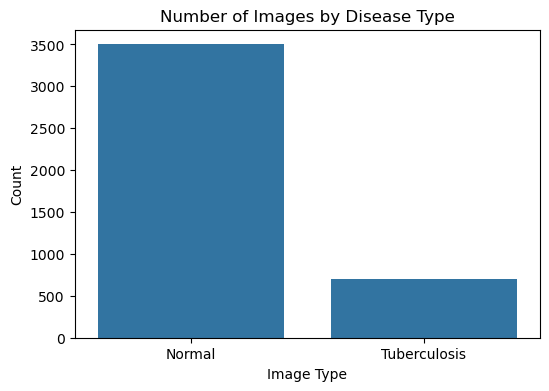

In [10]:
plt.figure(figsize=(6, 4))  
sns.countplot(x=df["Tuberculosis"])  
plt.title("Number of Images by Disease Type")  
plt.xticks(ticks=[0, 1], labels=["Normal", "Tuberculosis"])  
plt.xlabel("Image Type")  
plt.ylabel("Count")  
plt.show()  


## Split data into Train / Validation / Test sets

In [11]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["Tuberculosis"])  
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df["Tuberculosis"])  

# Check the size of each dataset  
print(f"Number of images in Train set: {train_df.shape[0]}")  
print(f"Number of images in Validation set: {val_df.shape[0]}")  
print(f"Number of images in Test set: {test_df.shape[0]}")  


Number of images in Train set: 3360
Number of images in Validation set: 420
Number of images in Test set: 420


## Show some sample images.

X-ray Images - Normal Group


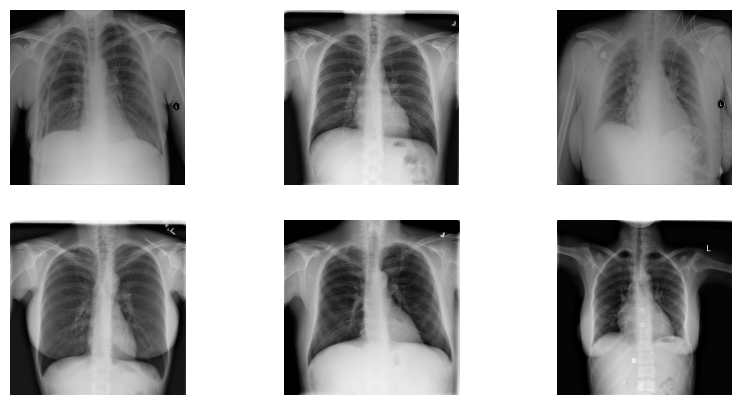

X-ray Images - Tuberculosis Group


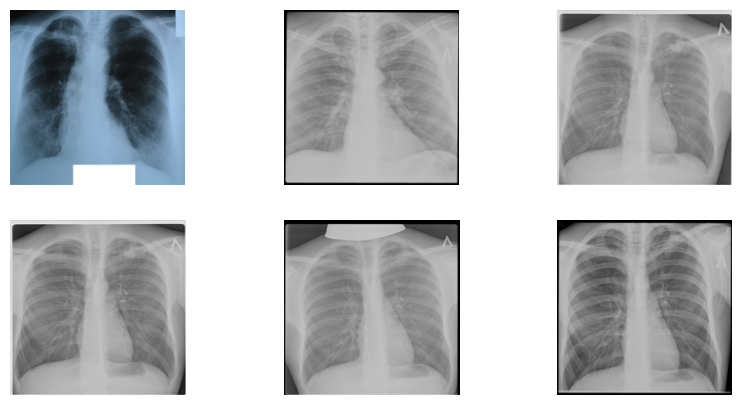

In [12]:
from glob import glob  # Ensure correct import

# Paths to images
SOURCE_PATH_NORM = os.path.join(DATASET_PATH, "Normal")
SOURCE_PATH_TB = os.path.join(DATASET_PATH, "Tuberculosis")

# Get the list of images
train_norm = glob(SOURCE_PATH_NORM + "/*.png")
train_tb = glob(SOURCE_PATH_TB + "/*.png")

# Display Normal images
print("X-ray Images - Normal Group")
plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    img = cv2.imread(train_norm[i])
    img = cv2.resize(img, (224, 224))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
plt.show()

# Display Tuberculosis images
print("X-ray Images - Tuberculosis Group")
plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    img = cv2.imread(train_tb[i])
    img = cv2.resize(img, (224, 224))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
plt.show()


## Prepare data and build a CNN & Transfer Learning model

In [13]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [15]:
import os
import pandas as pd

DATASET_PATH = r"D:\Nivaran_2.0\Tuberculosis\TB_Chest_Radiography_Database"

# Get the list of image files from the Normal and Tuberculosis directories
normal_images = os.listdir(os.path.join(DATASET_PATH, "Normal"))
tb_images = os.listdir(os.path.join(DATASET_PATH, "Tuberculosis"))

# Check the list of images
print("Number of Normal images:", len(normal_images))
print("Number of Tuberculosis images:", len(tb_images))

print("\nFirst 5 images of Normal:", normal_images[:5])
print("First 5 images of Tuberculosis:", tb_images[:5])


Number of Normal images: 3500
Number of Tuberculosis images: 700

First 5 images of Normal: ['Normal-1.png', 'Normal-10.png', 'Normal-100.png', 'Normal-1000.png', 'Normal-1001.png']
First 5 images of Tuberculosis: ['Tuberculosis-1.png', 'Tuberculosis-10.png', 'Tuberculosis-100.png', 'Tuberculosis-101.png', 'Tuberculosis-102.png']


## Create a DataFrame containing image information.

In [16]:
# Create DataFrame for Normal images
df_normal = pd.DataFrame({
    "Image": normal_images,
    "Tuberculosis": "0"  # Assign label 0 for normal images
})

# Create DataFrame for Tuberculosis images
df_tb = pd.DataFrame({
    "Image": tb_images,
    "Tuberculosis": "1"  # Assign label 1 for tuberculosis images
})

# Merge both DataFrames into one
df = pd.concat([df_normal, df_tb], ignore_index=True)

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the dataset
print(df.head())


             Image Tuberculosis
0  Normal-2568.png            0
1  Normal-2976.png            0
2  Normal-2554.png            0
3   Normal-852.png            0
4  Normal-1267.png            0


In [17]:
from sklearn.model_selection import train_test_split

# Split the dataset (80% train, 10% validation, 10% test)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["Tuberculosis"], random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df["Tuberculosis"], random_state=42)

# Check the number of images in each set
print(f"Train: {len(train_df)} images")
print(f"Validation: {len(val_df)} images")
print(f"Test: {len(test_df)} images")


Train: 3360 images
Validation: 420 images
Test: 420 images


In [18]:
# Update the image paths based on the label
train_df["Image"] = train_df.apply(lambda x: f"Normal/{x['Image']}" if x["Tuberculosis"] == "0" else f"Tuberculosis/{x['Image']}", axis=1)
val_df["Image"] = val_df.apply(lambda x: f"Normal/{x['Image']}" if x["Tuberculosis"] == "0" else f"Tuberculosis/{x['Image']}", axis=1)
test_df["Image"] = test_df.apply(lambda x: f"Normal/{x['Image']}" if x["Tuberculosis"] == "0" else f"Tuberculosis/{x['Image']}", axis=1)

# Check the first 5 rows to verify
print(train_df.head())


                       Image Tuberculosis
2354  Normal/Normal-1338.png            0
2146   Normal/Normal-982.png            0
1966   Normal/Normal-308.png            0
147    Normal/Normal-546.png            0
2950  Normal/Normal-2738.png            0


## Load data using ImageDataGenerator

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Define ImageDataGenerator with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test generators (without augmentation)
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load training data
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=DATASET_PATH,
    x_col="Image",
    y_col="Tuberculosis",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

# Load validation data
val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    directory=DATASET_PATH,
    x_col="Image",
    y_col="Tuberculosis",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

# Load test data
test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    directory=DATASET_PATH,
    x_col="Image",
    y_col="Tuberculosis",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False  # Ensure consistency in test results
)

# Check the data loading process
print(f"Training batches: {len(train_generator)}")
print(f"Validation batches: {len(val_generator)}")
print(f"Test batches: {len(test_generator)}")

Found 3360 validated image filenames belonging to 2 classes.
Found 420 validated image filenames belonging to 2 classes.
Found 420 validated image filenames belonging to 2 classes.
Training batches: 105
Validation batches: 14
Test batches: 14


## Check if the data has been loaded correctly

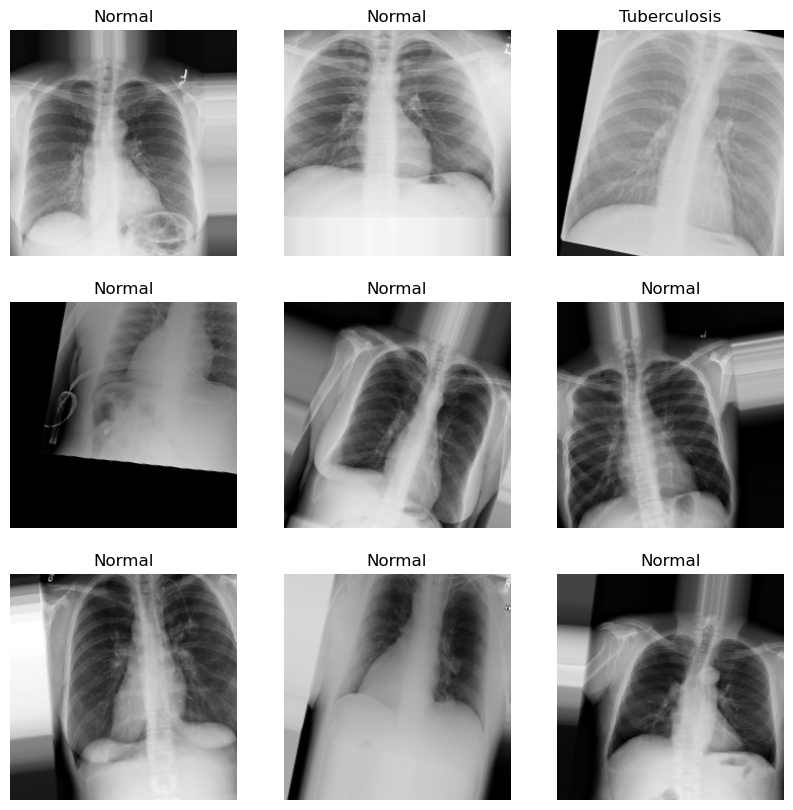

In [20]:

import matplotlib.pyplot as plt

# Get a batch of images
images, labels = next(train_generator)

# Display images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title("Tuberculosis" if labels[i] == 1 else "Normal")
    plt.axis("off")
plt.show()


## Train and Evaluate the Model

### Build a Shallow-CNN Model for Tuberculosis Detection

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Initialize the Shallow-CNN model
shallow_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Reduce overfitting
    Dense(1, activation='sigmoid')  # 1 neuron output with sigmoid activation
])

# Compile the model
shallow_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model architecture
shallow_cnn.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,244,929 (84.86 MB)

 Trainable params: 22,244,929 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

### Configure Callbacks in Keras

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1)
]
'''
EarlyStopping : 
Monitors "val_loss" (validation loss).
Stops training if validation loss does not improve for 5 consecutive epochs (patience=5).
Restores the best model weights before stopping (restore_best_weights=True), ensuring the final model is the best one observed during training.

ReduceLROnPlateau : 
Monitors "val_loss" (validation loss).
If val_loss does not improve for 3 consecutive epochs (patience=3), it reduces the learning rate.
The learning rate is reduced by a factor of 0.2 (factor=0.2), meaning it becomes 20% of its current value.
verbose=1 prints updates when the learning rate changes.'''

### Train the Model (Shallow-CNN)

In [24]:
history = shallow_cnn.fit(
    train_generator,
    validation_data=val_generator,
    epochs=2, # Train for a maximum of 20 epochs
    callbacks=callbacks
)

Epoch 1/2
105/105 ━━━━━━━━━━━━━━━━━━━━ 550s 5s/step - accuracy: 0.8604 - loss: 0.6413 - val_accuracy: 0.8929 - val_loss: 0.2083 - learning_rate: 0.0010
Epoch 2/2
105/105 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.8988 - loss: 0.2512 - val_accuracy: 0.9238 - val_loss: 0.1347 - learning_rate: 0.0010


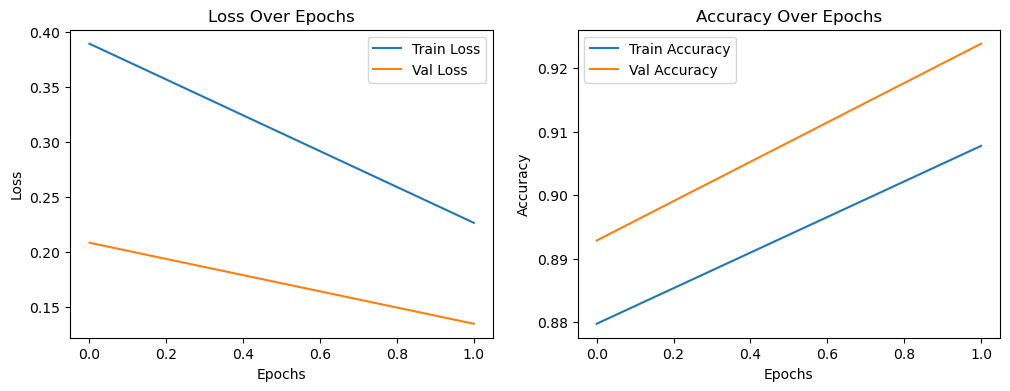

In [25]:
import matplotlib.pyplot as plt

# Plot loss and accuracy
def plot_history(history):
    plt.figure(figsize=(12,4))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    plt.show()

# Call the function to plot training history
plot_history(history)


### Improve the Model with Transfer Learning

In [26]:
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential

### Function to Build a Transfer Learning Model

In [27]:
def build_transfer_learning_model(base_model):
    base_model.trainable = False  # Freeze the layers of the pre-trained model

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # 1 neuron output with sigmoid for binary classification
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


### Choosing a Transfer Learning Model

In [28]:
# Select Model
resnet_model = build_transfer_learning_model(ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3)))
densenet_model = build_transfer_learning_model(DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3)))
efficientnet_model = build_transfer_learning_model(EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3)))

# Display model architecture
resnet_model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 41s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Train the Transfer Learning Model

In [29]:
history_resnet = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=2,
    callbacks=callbacks
)

Epoch 1/2
105/105 ━━━━━━━━━━━━━━━━━━━━ 344s 3s/step - accuracy: 0.8099 - loss: 0.5120 - val_accuracy: 0.8333 - val_loss: 0.4544 - learning_rate: 0.0010
Epoch 2/2
105/105 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.8297 - loss: 0.4766 - val_accuracy: 0.8333 - val_loss: 0.4495 - learning_rate: 0.0010


14/14 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.8444 - loss: 0.4326
ResNet50 accuracy on the test set: 83.33%


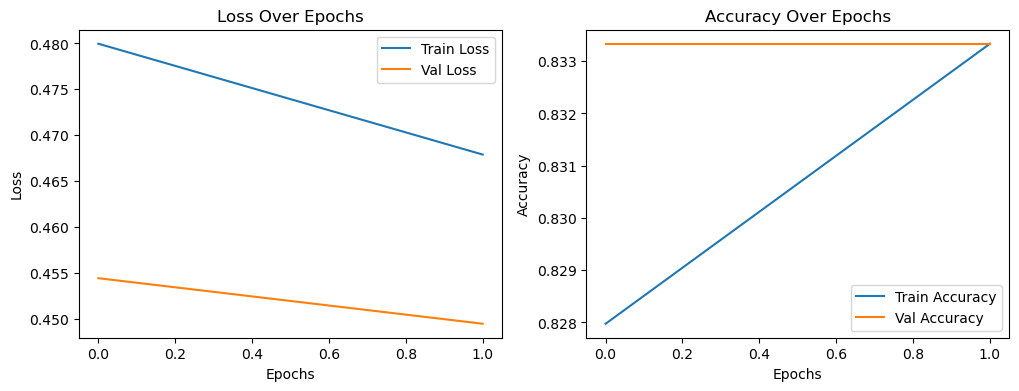

In [30]:
test_loss, test_acc = resnet_model.evaluate(test_generator)
print(f"ResNet50 accuracy on the test set: {test_acc*100:.2f}%")
plot_history(history_resnet)


### Fine-tuning to Optimize the Transfer Learning Model

#### Unfreeze the Model Layers

In [31]:
# Unfreeze the last 50% of layers
for layer in resnet_model.layers[0].layers[-50:]:
    layer.trainable = True  # Allow weight updates during fine-tuning

# Reduce the learning rate to prevent damaging the pre-trained weights
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
                     loss="binary_crossentropy", 
                     metrics=["accuracy"])

# Check the trainable status of layers
for layer in resnet_model.layers[0].layers:
    print(layer.name, ":", "Trainable" if layer.trainable else "Frozen")


input_layer_1 : Frozen
conv1_pad : Frozen
conv1_conv : Frozen
conv1_bn : Frozen
conv1_relu : Frozen
pool1_pad : Frozen
pool1_pool : Frozen
conv2_block1_1_conv : Frozen
conv2_block1_1_bn : Frozen
conv2_block1_1_relu : Frozen
conv2_block1_2_conv : Frozen
conv2_block1_2_bn : Frozen
conv2_block1_2_relu : Frozen
conv2_block1_0_conv : Frozen
conv2_block1_3_conv : Frozen
conv2_block1_0_bn : Frozen
conv2_block1_3_bn : Frozen
conv2_block1_add : Frozen
conv2_block1_out : Frozen
conv2_block2_1_conv : Frozen
conv2_block2_1_bn : Frozen
conv2_block2_1_relu : Frozen
conv2_block2_2_conv : Frozen
conv2_block2_2_bn : Frozen
conv2_block2_2_relu : Frozen
conv2_block2_3_conv : Frozen
conv2_block2_3_bn : Frozen
conv2_block2_add : Frozen
conv2_block2_out : Frozen
conv2_block3_1_conv : Frozen
conv2_block3_1_bn : Frozen
conv2_block3_1_relu : Frozen
conv2_block3_2_conv : Frozen
conv2_block3_2_bn : Frozen
conv2_block3_2_relu : Frozen
conv2_block3_3_conv : Frozen
conv2_block3_3_bn : Frozen
conv2_block3_add : Froz

#### Retrain the Model (Fine-tuning)

In [32]:
history_finetune = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 449s 4s/step - accuracy: 0.8351 - loss: 0.4489 - val_accuracy: 0.8333 - val_loss: 0.5135 - learning_rate: 1.0000e-05
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 409s 4s/step - accuracy: 0.8610 - loss: 0.3354 - val_accuracy: 0.8357 - val_loss: 0.4117 - learning_rate: 1.0000e-05
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 423s 4s/step - accuracy: 0.8808 - loss: 0.2923 - val_accuracy: 0.8762 - val_loss: 0.2815 - learning_rate: 1.0000e-05
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 516s 5s/step - accuracy: 0.8935 - loss: 0.2582 - val_accuracy: 0.8857 - val_loss: 0.2343 - learning_rate: 1.0000e-05
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 30043s 289s/step - accuracy: 0.9026 - loss: 0.2422 - val_accuracy: 0.9214 - val_loss: 0.1837 - learning_rate: 1.0000e-05
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2443s 23s/step - accuracy: 0.9167 - loss: 0.2064 - val_accuracy: 0.9476 - val_loss: 0.1534 - learning_rate: 1.0000e-05
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 380s 4s/step

#### Evaluating the Fine-Tuned Model on the Test Set

14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9854 - loss: 0.0742
Accuracy of the Fine-Tuned model on the test set: 97.62%


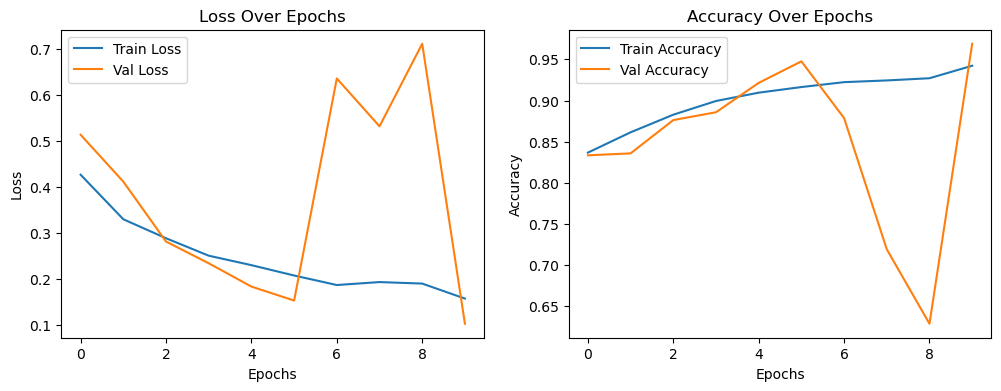

In [33]:
test_loss, test_acc = resnet_model.evaluate(test_generator)
print(f"Accuracy of the Fine-Tuned model on the test set: {test_acc*100:.2f}%")
plot_history(history_finetune)


In [34]:
# Lưu mô hình
resnet_model.save("tuberculosis_classifier.h5")
print("Mô hình đã được lưu thành công!")

Mô hình đã được lưu thành công!


In [35]:
resnet_model.save("my_model.keras")